# Stability and convergence criteria for the linear response

In [1]:
%autosave 0
from BigDFT import Logfiles as lf
from BigDFT import Calculators as C
from futile import Yaml
import matplotlib.pyplot as plt
import numpy as np
import scipy.fftpack
import sys
sys.path.insert(0,'../')
import Routine as R
outputpath = 'linear-response/'

Autosave disabled


The aim of this notebook is to perform an assessment of the reliability of the results given by the linear response. 
First of all we analyze the absorption spectrum and discuss its stability in terms of both the number of virtual orbitals and the dimension of the simulation box. 
Then we try to define a set of tools for perfoming a (semi)-automatic analysis of the excitonic states of the system. We want to define a procedure that is able to state if a given excitation can be considered as "well-sampled" or not (using the given values of number of virtual states and dimension of the simulation box)

We set some general parameters and perform the analysis reading the results obtained in the others notebook

In [2]:
numOrb = 5
rmult = [7.0, 9.0]
nVirtMax = [303, 279]

## Stability of the absorption spectrum

In [3]:
spectrum = {}
Data = {}

%cd $outputpath
for ind, r in enumerate(rmult):
    filename = 'log/spectrum_rmult'+str(r)+'.yaml '
    spectrum[r] = Yaml.load(filename)
    logpath = 'log/log-NumVirt_'+str(nVirtMax[ind])+'.yaml'
    log = !ls $logpath
    Data[r] = lf.Logfile(log[0])
%cd ..

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/linear-response
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2


In [5]:
print spectrum[7.0].keys()
print spectrum[9.0].keys()

[32, 64, 128, 192, 256, 303]
[32, 64, 128, 192, 256, 279]


Firstly we analyze the convergence of the spectrum in function of the number of virtual orbitals

rmult =  9.0


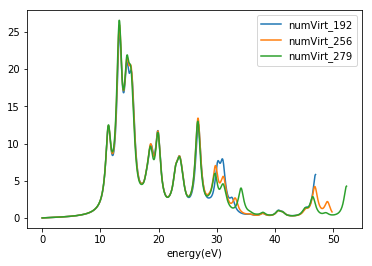

In [6]:
na_plot = [192,256,279,303]
r = 9.0
print 'rmult = ', r
for n in na_plot:
    if n in spectrum[r]:
        plt.plot(spectrum[r][n]['omega'],spectrum[r][n]['spectrum'],label='numVirt_'+str(n))
plt.legend()
plt.xlabel('energy(eV)')
plt.show()

The analysis of the plot for the two values of rmult show that:
* For rmult = 7.0 the spectrum is stable up to 40 eV
* For rmult = 9.0 the spectrum is stable up to 30 eV
These results indicate that it is interesting to compare the spectrum for the two values of rmult up to 30 eV

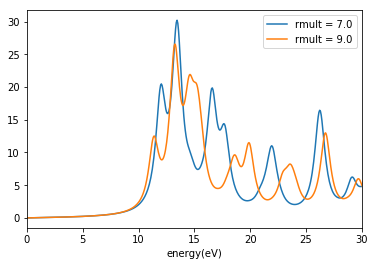

In [7]:
for r in rmult:
    na = spectrum[r].keys()[-1]
    plt.plot(spectrum[r][na]['omega'],spectrum[r][na]['spectrum'],label='rmult = '+str(r))
plt.xlim(0, 30)
plt.legend()
plt.xlabel('energy(eV)')
plt.show()

The spectrum are different and we want to understand why.

## Stability of the relevant excitations

To understand why the spectrum changes from rmult 7 to 9 we perform an analysis of the properties of the excitations that are relevant for the costruction of the spectrum e compare the results for the two values of rmult.

In [8]:
excitations = {}

%cd $outputpath
for ind, r in enumerate(rmult):
    filename = 'log/excitations_rmult'+str(r)+'.yaml '
    excitations[r] = Yaml.load(filename)
%cd ..

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/linear-response
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2


First of all we display the lower energy transitions for both values of the box

In [61]:
for r in rmult:
    allTr, trEnergy = R.allTransitions(excitations[r])
    print allTr[:12]
for r in rmult:
    allTr, trEnergy = R.allTransitions(excitations[r])
    print trEnergy[:12]

['3,4to1,2-0', '5to1-0+5to2-0', '3,4to1,2-1', '3,4to1,2-2', '5to1-1+5to2-1', '3,4to1,2-3+3,4to1,2-4', '3,4to1,2-5', '3,4to1,2-6', '5to3-0', '5to3-1', '5to4-0', '5to4-1']
['3,4to1,2-0', '5to1-0+5to2-0', '3,4to1,2-1', '3,4to1,2-2', '5to1-1+5to2-1', '3,4to1,2-3+3,4to1,2-4', '3,4to1,2-5', '3,4to1,2-6', '2to1-0+2to2-0', '5to3-0', '5to3-1', '5to4-0']
[7.3080917330483448, 7.3437845773699291, 8.4362382431192238, 8.4391778492061906, 8.9000023134932, 9.350691149311718, 9.8504704471102578, 9.8531346468570984, 10.909838950460374, 11.329468109976384, 11.94476225779843, 11.998081393775692]
[7.3381084021054424, 7.3544739941568658, 8.4473374858042121, 8.4503246668343461, 8.9296493035285387, 9.3495640362899479, 9.8545856543633548, 9.8573183553278803, 10.247196363272774, 10.542760009518792, 10.835078753875917, 11.354487481245043]


Now we start to analyze the transitions more relevant for the specrtum. We plot the oscillator strenght

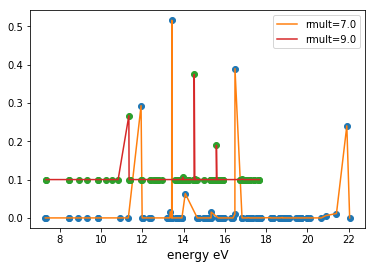

In [62]:
offs = 0.0
for r in rmult:
    allTr, trEnergy = R.allTransitions(excitations[r])
    na = excitations[r].keys()[-1]
    oscStrenght = []
    for tr in allTr:
        oscStrenght.append(excitations[r][na]['transitions'][tr]['oscStrenght'])
    plt.plot(trEnergy,offs+np.array(oscStrenght),'o')
    plt.plot(trEnergy,offs+np.array(oscStrenght),label = 'rmult='+str(r))
    offs+=0.1
plt.legend()
plt.xlabel('energy eV', size=12)
plt.show()

Build the dictionary with the most relevant transitions

In [63]:
relTransitions = {}
relEnergy = {}
relOscStrenght = {}
for r in rmult:
    relTransitions[r] = []
    relEnergy[r] = []
    relOscStrenght[r] = []
    na = excitations[r].keys()[-1]
    allTr, trEnergy = R.allTransitions(excitations[r])
    for ind,tr in enumerate(allTr):
        osc = excitations[r][na]['transitions'][tr]['oscStrenght'] 
        if  osc > 0.1:
            relTransitions[r].append(tr)
            relEnergy[r].append(trEnergy[ind])
            relOscStrenght[r].append(osc)
        

In [64]:
for r in rmult:
    print relTransitions[r]
    print relEnergy[r]
    print relOscStrenght[r]

['5to4-0', '3,4to5,6-5+3,4to5,6-6', '2to7-1', '2to30-0']
[11.94476225779843, 13.431632699878232, 16.492041953851057, 21.907486314446217]
[0.2926858196809133, 0.5155401131505235, 0.3891823859612723, 0.2402204650804506]
['5to4-0', '2,5to4,22-1']
[11.354487481245043, 14.519996884955464]
[0.16684251889565177, 0.2741581074909661]


In [ ]:
##############################################################################

We read the results for the excitations and for the log of DFT and organize them in a dictionary according to rmult

In [2]:
numOrb = 5
rmult = [7.0, 9.0]
nVirtMax = [303, 279]
excitations = {}
Data = {}

%cd $outputpath
for ind, r in enumerate(rmult):
    filename = 'log/excitations_rmult'+str(r)+'.yaml '
    excitations[r] = Yaml.load(filename)
    logpath = 'log/log-NumVirt_'+str(nVirtMax[ind])+'.yaml'
    log = !ls $logpath
    Data[r] = lf.Logfile(log[0])
%cd ..

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/linear-response
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2


In [3]:
#excitations[7][32]['transitions']

We display the list of the labels of all the transitions considered in exc, using the appropriate method. The list of the transition is sorted in order of increasing energy.

In [4]:
reload(R)
allTr = R.allTransitions(excitations[7.0])
print allTr[0:]

['3,4to1,2-0', '5to1-0+5to2-0', '3,4to1,2-1', '3,4to1,2-2', '5to1-1+5to2-1', '3,4to1,2-3+3,4to1,2-4', '3,4to1,2-5', '3,4to1,2-6', '2to1,2-1+2to1,2-0', '5to3-0', '5to3-1', '5to4-0', '5to4-1', '5to6-0+5to5-0', '5to6-1+5to5-1', '3to3-0+4to3-0', '3to3-1+4to3-1', '2to1-0+2to2-0', '2to1-1+2to2-1', '2to2-1', '2to1-1', '3,4to5,6-0', '5to7-0', '5to7-1', '3,4to5,6-1']


## Stability of the energy of the excitonic states

As a first criterium for study of the reliability of an excitation we analyze the stability of its energy. We consider an excitation as well-sampled if two condition are satisfied:
* the variation of its energy as the number of virtual states is increased is below a given threshold
* the values of the energy of the excitation obtained for two different box are equal with a given tolerance 

In [5]:
selLab = allTr[1:2]
print selLab

['5to1-0+5to2-0']


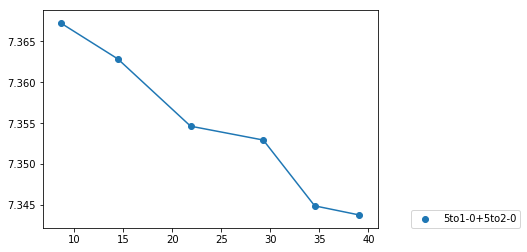

In [6]:
%matplotlib inline
r = 7
R.pltTrLabel(selLab,excitations[r],Data[r],numOrb,True)

### Analysis of the dipendence of the energy to the number of virtual orbitals

### Analysis of the dipendence of the energy with respect to the box size

In [31]:
# box dipendence homo-lumo gap
v = []
for d in Data.values():
    v.append(27.211*(d.evals[0][0][numOrb]-d.evals[0][0][numOrb-1]))
print 'Delta HOMO-LUMO', abs(v[0]-v[1])
# energy highest bound virtual state (state number seven)
v = []
for d in Data.values():
    v.append(27.211*d.evals[0][0][6])
print 'Delta highest bound', abs(v[0]-v[1])

Delta HOMO-LUMO 0.00111483372394
Delta highest bound 0.00136220664727


In [32]:
selLab = allTr[0:1]
selLab

['3,4to1,2-0']

In [41]:
for s in selLab:
    print excitations[7][128]['transitions'][s]['eng']
    print excitations[9][279]['transitions'][s]['eng']
    

7.34587283931
7.33810840211


Cosi non ha molto senso, è un confronto fatto con un numero di orbitali vuoti diverso e una energia massima molto diversa (anche a causa del collasso del continuo), credo vada fatto scegliendo il numero di orbitali vuoti del caso r=7 in modo che la emax coincida per le 2 box....